<a href="https://colab.research.google.com/github/kaushikkumarkr/IDS/blob/main/IDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Necessary Library**
Commonly used libraries are imported here. Libraries for models may be imported when they will be used in their cell.

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d solarmainframe/ids-intrusion-csv

ids-intrusion-csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/ids-intrusion-csv.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import numpy as np
import pandas as pd
import os, re, time, math, tqdm, itertools
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.offline as pyo
import seaborn as sns

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SequentialFeatureSelector

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


!pip install interpret
from interpret.blackbox import LimeTabular
from interpret import show

import lime
import lime.lime_tabular
from lime.lime_tabular import LimeTabularExplainer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **Load Dataset**

In [ ]:
for dirname, _, filenames in os.walk('/content/ids-intrusion-csv.zip'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# **Read Dataset**

In [ ]:
%%time
network_data_d1 = pd.read_csv("/content/02-14-2018.csv", low_memory=False)

CPU times: user 18.8 s, sys: 6.03 s, total: 24.8 s
Wall time: 37.4 s


# **EDA**

## **Data Properties**

In [ ]:
network_data_d1.shape
print ('Number of rows (Samples): ' , network_data_d1.shape[0])
print ('Number of columns (Features): ' , network_data_d1.shape[1])

Number of rows (Samples):  1048575
Number of columns (Features):  80


In [ ]:
network_data_d1

Dst Port  Protocol            Timestamp  Flow Duration  Tot Fwd Pkts  \
0               0         0  14/02/2018 08:31:01      112641719             3   
1               0         0  14/02/2018 08:33:50      112641466             3   
2               0         0  14/02/2018 08:36:39      112638623             3   
3              22         6  14/02/2018 08:40:13        6453966            15   
4              22         6  14/02/2018 08:40:23        8804066            14   
...           ...       ...                  ...            ...           ...   
1048570        80         6  14/02/2018 10:53:23       10156986             5   
1048571        80         6  14/02/2018 10:53:33            117             2   
1048572        80         6  14/02/2018 10:53:28        5095331             3   
1048573        80         6  14/02/2018 10:53:28        5235511             3   
1048574       443         6  14/02/2018 10:53:28        5807256             6   

         Tot Bwd Pkts  TotLen Fwd Pkts  TotLen Bwd Pkts  Fwd Pkt Len Max  \
0                   0                0                0                0   
1                   0                0                0                0   
2                   0                0                0                0   
3                  10             1239             2273              744   
4                  11             1143             2209              744   
...               ...              ...              ...              ...   
1048570             5             1089             1923              587   
1048571             0                0                0                0   
1048572             1                0                0                0   
1048573             1                0                0                0   
1048574             4              327              145              245   

         Fwd Pkt Len Min  ...  Fwd Seg Size Min  Active Mean  Active Std  \
0                      0  ...                 0          0.0         0.0   
1                      0  ...                 0          0.0         0.0   
2                      0  ...                 0          0.0         0.0   
3                      0  ...                32          0.0         0.0   
4                      0  ...                32          0.0         0.0   
...                  ...  ...               ...          ...         ...   
1048570                0  ...                20          0.0         0.0   
1048571                0  ...                20          0.0         0.0   
1048572                0  ...                20          0.0         0.0   
1048573                0  ...                20          0.0         0.0   
1048574                0  ...                20     291569.0         0.0   

         Active Max  Active Min   Idle Mean    Idle Std  Idle Max  Idle Min  \
0                 0           0  56320859.5  139.300036  56320958  56320761   
1                 0           0  56320733.0  114.551299  56320814  56320652   
2                 0           0  56319311.5  301.934596  56319525  56319098   
3                 0           0         0.0    0.000000         0         0   
4                 0           0         0.0    0.000000         0         0   
...             ...         ...         ...         ...       ...       ...   
1048570           0           0         0.0    0.000000         0         0   
1048571           0           0         0.0    0.000000         0         0   
1048572           0           0         0.0    0.000000         0         0   
1048573           0           0         0.0    0.000000         0         0   
1048574      291569      291569   5515650.0    0.000000   5515650   5515650   

          Label  
0        Benign  
1        Benign  
2        Benign  
3        Benign  
4        Benign  
...         ...  
1048570  Benign  
1048571  Benign  
1048572  Benign  
1048573  Benign  
1048574  Benign  

[1048575 rows x 80 columns]

In [ ]:
network_data_d1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 80 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Dst Port           1048575 non-null  int64  
 1   Protocol           1048575 non-null  int64  
 2   Timestamp          1048575 non-null  object 
 3   Flow Duration      1048575 non-null  int64  
 4   Tot Fwd Pkts       1048575 non-null  int64  
 5   Tot Bwd Pkts       1048575 non-null  int64  
 6   TotLen Fwd Pkts    1048575 non-null  int64  
 7   TotLen Bwd Pkts    1048575 non-null  int64  
 8   Fwd Pkt Len Max    1048575 non-null  int64  
 9   Fwd Pkt Len Min    1048575 non-null  int64  
 10  Fwd Pkt Len Mean   1048575 non-null  float64
 11  Fwd Pkt Len Std    1048575 non-null  float64
 12  Bwd Pkt Len Max    1048575 non-null  int64  
 13  Bwd Pkt Len Min    1048575 non-null  int64  
 14  Bwd Pkt Len Mean   1048575 non-null  float64
 15  Bwd Pkt Len Std    1048575 non-n

In [ ]:
network_data_d1['Label'].value_counts()

Benign            667626
FTP-BruteForce    193360
SSH-Bruteforce    187589
Name: Label, dtype: int64

## **Data Visualizations**

### **Bar Chart**

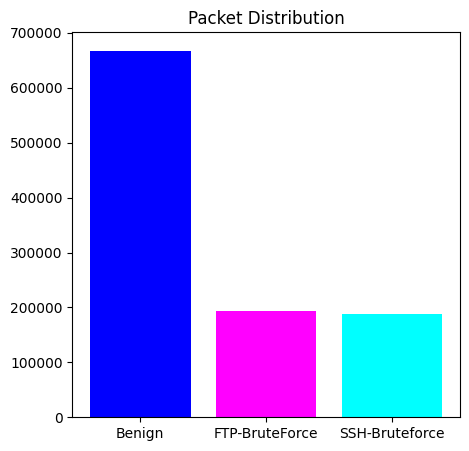

In [ ]:
# bar chart of packets label
plt.figure(figsize=(5, 5))
plt.title('Packet Distribution')
plt.bar(x=['Benign', 'FTP-BruteForce', 'SSH-Bruteforce'], height=network_data_d1['Label'].value_counts(), color=['blue', 'magenta', 'cyan'])
p = plt.gcf()

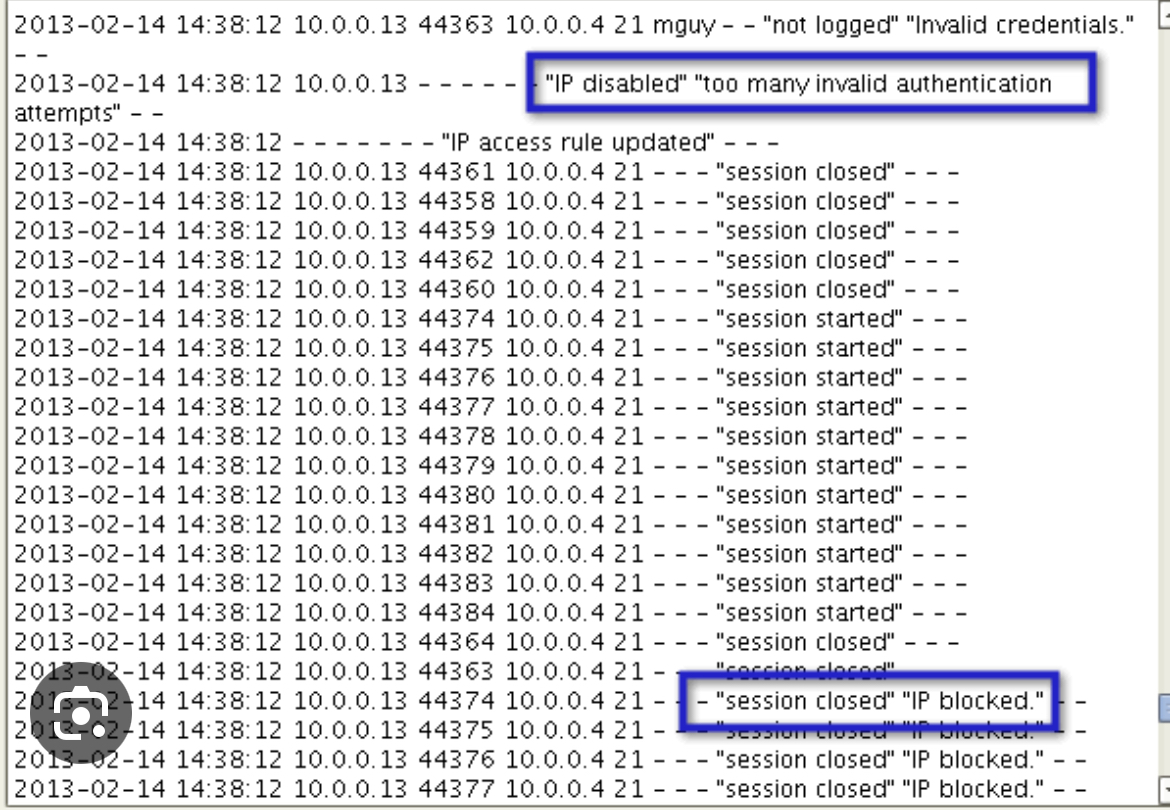

### **Pie Chart**

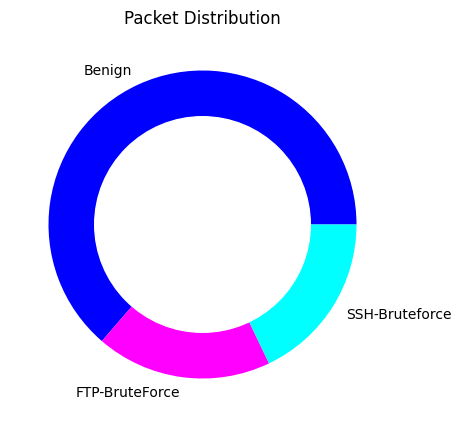

In [ ]:
# pie chart of packets label
plt.figure(figsize=(5, 5))
circle = plt.Circle((0, 0), 0.7, color='white')
plt.title('Packet Distribution')
plt.pie(network_data_d1['Label'].value_counts(), labels=['Benign', 'FTP-BruteForce', 'SSH-Bruteforce'], colors=['blue', 'magenta', 'cyan'])
p = plt.gcf()
p.gca().add_artist(circle)

## **Data Preprocessing**

### **Temporarily Hold Data**
This helps to code while manupulating the data. If something unexpected operation happend on data, strat a run from this cell is enough. Don't have to run full notebook.

In [ ]:

temp_network_data_d1 = network_data_d1
#network_data_d1 = temp_network_data_d1

### **Drop Infinate and Null**

In [ ]:
print (network_data_d1.shape)

# replace infinity value as null value
network_data_d1 = network_data_d1.replace(["Infinity", "infinity"], np.inf)
network_data_d1 = network_data_d1.replace([np.inf, -np.inf], np.nan)

# drop all null values
network_data_d1.dropna(inplace=True)

print (network_data_d1.shape)

(1048575, 80)
(1044751, 80)


### **Drop Unnecessary Column**

In [ ]:
network_data_d1.drop(columns="Timestamp", inplace=True)
print (network_data_d1.shape)

(1044751, 79)


### **Data Balancing**

In [ ]:
# split data into features and target
X=network_data_d1.drop(["Label"], axis=1)
y=network_data_d1["Label"]

#### **Oversampling**

In [ ]:
# %%time
# applying oversampling
ros = RandomOverSampler()
X_balanced, y_balanced = ros.fit_resample(X, y)

#### **SMOTE**

In [ ]:
# # %%time
# # applying SMOTE
# smote = SMOTE(random_state=42)
# X_balanced, y_balanced = smote.fit_resample(X, y)

In [ ]:
network_data_d1 = pd.concat([X_balanced, y_balanced], axis=1)
print (network_data_d1.shape)
print(network_data_d1['Label'].value_counts())

(1991424, 79)
Benign            663808
FTP-BruteForce    663808
SSH-Bruteforce    663808
Name: Label, dtype: int64


### **Data Normalization**

In [ ]:
# list numeric columns
numeric_cols = network_data_d1.select_dtypes(include=[np.number]).columns.tolist()
print(numeric_cols)

['Dst Port', 'Protocol', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt', 'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Fwd Byts/b Avg', 'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Bwd Byts/b Avg', 'B

#### **Z Score**

In [ ]:
# # %%time
# # apply z-score normalization
# std = StandardScaler()
# network_data_d1[numeric_cols] = std.fit_transform(network_data_d1[numeric_cols])

#### **Min Max**

In [ ]:
# # %%time
# # apply min-max normalization
# mnmx = MinMaxScaler()
# network_data_d1[numeric_cols] = mnmx.fit_transform(network_data_d1[numeric_cols])

#### **Robust**

In [ ]:
# %%time
# apply robust normalization
rbst = RobustScaler()
network_data_d1[numeric_cols] = rbst.fit_transform(network_data_d1[numeric_cols])

In [ ]:
network_data_d1

Dst Port  Protocol  Flow Duration  Tot Fwd Pkts  Tot Bwd Pkts  \
0         -0.6875      -6.0     315.595456      0.285714     -0.166667   
1         -0.6875      -6.0     315.594747      0.285714     -0.166667   
2         -0.6875      -6.0     315.586782      0.285714     -0.166667   
3          0.0000       0.0      18.082434      2.000000      1.500000   
4          0.0000       0.0      24.666859      1.857143      1.666667   
...           ...       ...            ...           ...           ...   
1991419    0.0000       0.0       0.941538      3.000000      3.500000   
1991420    0.0000       0.0      -0.000036      0.000000      0.000000   
1991421    0.0000       0.0      -0.000034      0.000000      0.000000   
1991422    0.0000       0.0       1.099838      3.285714      3.166667   
1991423    0.0000       0.0      -0.000039      0.000000      0.000000   

         TotLen Fwd Pkts  TotLen Bwd Pkts  Fwd Pkt Len Max  Fwd Pkt Len Min  \
0               0.000000         0.000000         0.000000              0.0   
1               0.000000         0.000000         0.000000              0.0   
2               0.000000         0.000000         0.000000              0.0   
3               2.723077         2.667840         3.683168              0.0   
4               2.512088         2.592723         3.683168              0.0   
...                  ...              ...              ...              ...   
1991419         4.202198         3.127934         3.168317              0.0   
1991420         0.000000         0.000000         0.000000              0.0   
1991421         0.000000         0.000000         0.000000              0.0   
1991422         4.237363         3.127934         3.168317              0.0   
1991423         0.000000         0.000000         0.000000              0.0   

         Fwd Pkt Len Mean  ...  Fwd Seg Size Min  Active Mean  Active Std  \
0                0.000000  ...              -1.6          0.0         0.0   
1                0.000000  ...              -1.6          0.0         0.0   
2                0.000000  ...              -1.6          0.0         0.0   
3                1.471715  ...               0.0          0.0         0.0   
4                1.454661  ...               0.0          0.0         0.0   
...                   ...  ...               ...          ...         ...   
1991419          1.548492  ...               0.0          0.0         0.0   
1991420          0.000000  ...               0.0          0.0         0.0   
1991421          0.000000  ...               0.0          0.0         0.0   
1991422          1.431329  ...               0.0          0.0         0.0   
1991423          0.000000  ...               0.0          0.0         0.0   

         Active Max  Active Min   Idle Mean    Idle Std    Idle Max  \
0               0.0         0.0  56320859.5  139.300036  56320958.0   
1               0.0         0.0  56320733.0  114.551299  56320814.0   
2               0.0         0.0  56319311.5  301.934596  56319525.0   
3               0.0         0.0         0.0    0.000000         0.0   
4               0.0         0.0         0.0    0.000000         0.0   
...             ...         ...         ...         ...         ...   
1991419         0.0         0.0         0.0    0.000000         0.0   
1991420         0.0         0.0         0.0    0.000000         0.0   
1991421         0.0         0.0         0.0    0.000000         0.0   
1991422         0.0         0.0         0.0    0.000000         0.0   
1991423         0.0         0.0         0.0    0.000000         0.0   

           Idle Min           Label  
0        56320761.0          Benign  
1        56320652.0          Benign  
2        56319098.0          Benign  
3               0.0          Benign  
4               0.0          Benign  
...             ...             ...  
1991419         0.0  SSH-Bruteforce  
1991420         0.0  SSH-Bruteforce  
1991421         0.0  SSH-Bruteforce  
1991422      

## **Feature Selection**

### **Drop Constant Column**

In [ ]:
# drop the constant columns (which varience is 0)
variances = network_data_d1.var(numeric_only=True)
constant_columns = variances[variances == 0].index    #it means all values are same then variance=0
network_data_d1 = network_data_d1.drop(constant_columns, axis=1)

print (network_data_d1.shape)

(1991424, 69)


### **Check and Drop Duplicate Column**

In [ ]:
duplicates = set()
for i in range(0, len(network_data_d1.columns)):
    col1 = network_data_d1.columns[i]
    for j in range(i+1, len(network_data_d1.columns)):
        col2 = network_data_d1.columns[j]
        if(network_data_d1[col1].equals(network_data_d1[col2])):
            duplicates.add(col2)

print (duplicates)
network_data_d1.drop(duplicates, axis=1, inplace=True)
print (network_data_d1.shape)

{'Subflow Fwd Pkts', 'Fwd Seg Size Avg', 'Subflow Bwd Byts', 'Subflow Bwd Pkts', 'Subflow Fwd Byts', 'SYN Flag Cnt'}
(1991424, 63)


### **Encode Target Label**

In [ ]:
# encode the target feature
network_data_d1['Label'] = network_data_d1['Label'].apply(lambda x: 0 if x == 'Benign' else 1)
print(network_data_d1['Label'].unique())

[0 1]


### **Drop Column Based on Correlations**

#### **Correlations of Data**

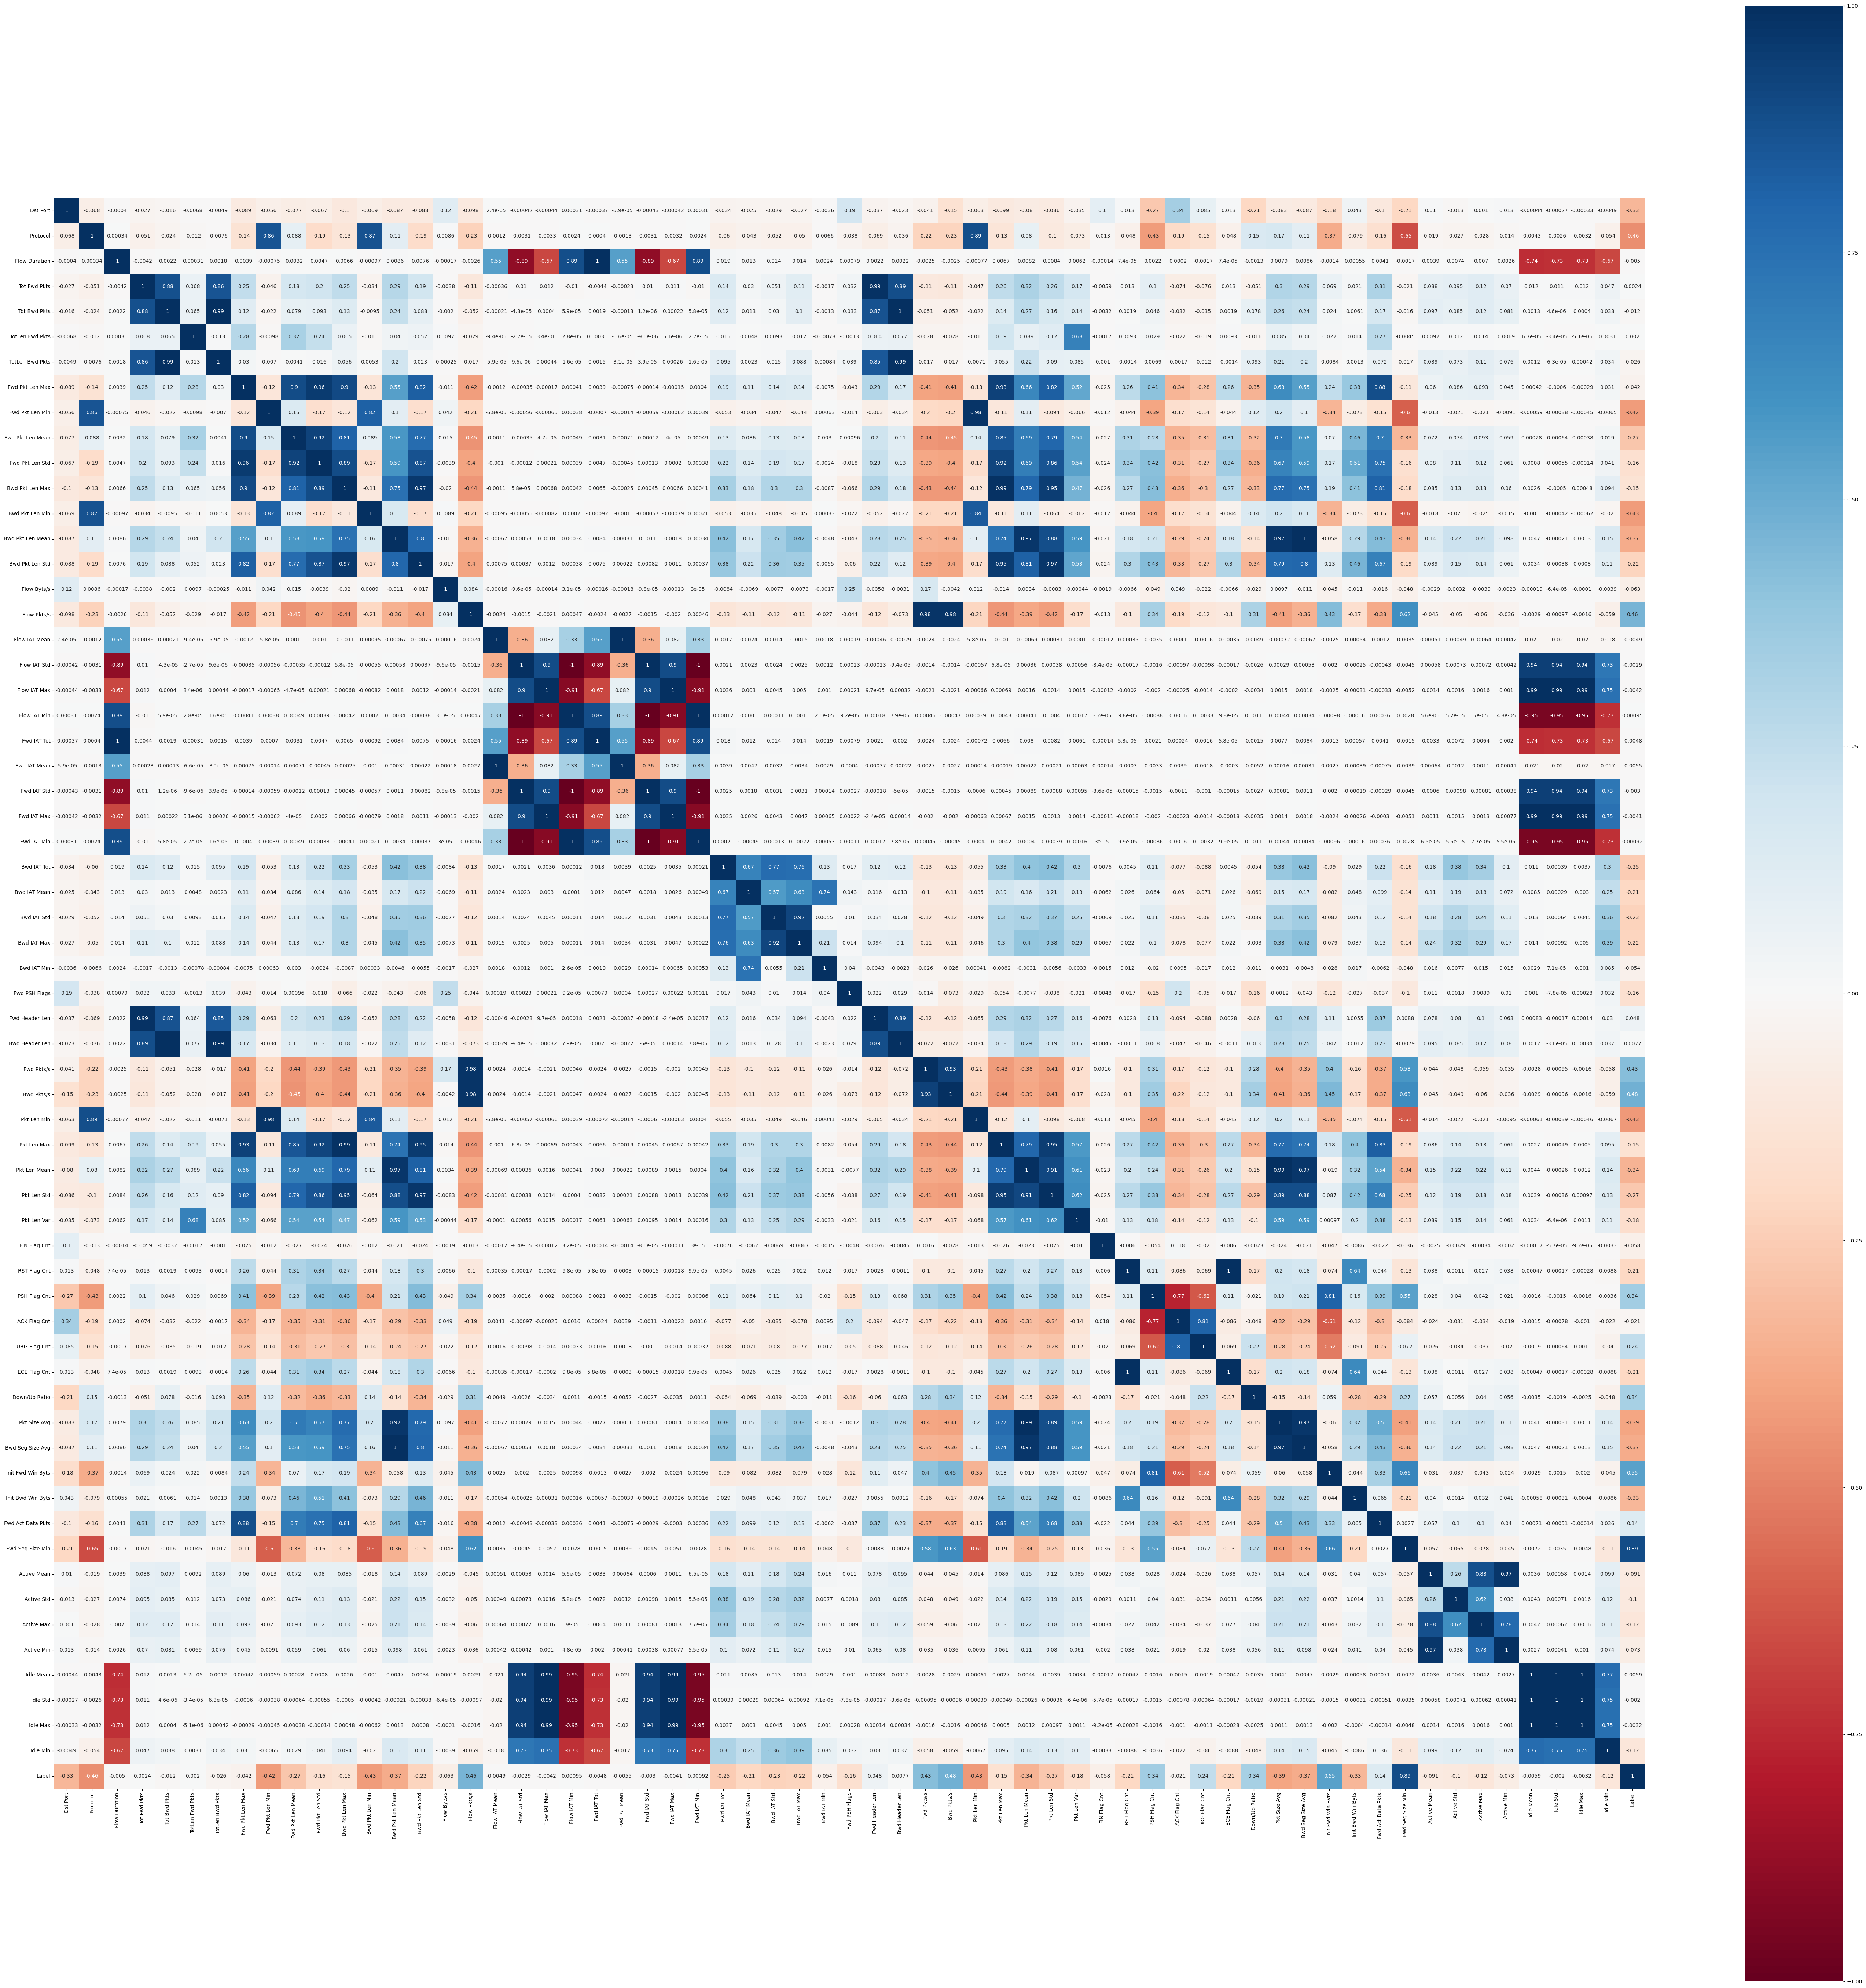

In [ ]:
# pearson correlation heatmap
plt.figure(figsize=(70, 70))
corr = network_data_d1.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='RdBu', vmin=-1, vmax=1, square=True) # annot=True
plt.show()

#### **Drop Columns**

In [ ]:
correlated_col = set()
is_correlated = [True] * len(corr.columns)
threshold = 0.85
for i in range (len(corr.columns)):
    if(is_correlated[i]):
        for j in range(i):
          if (corr.iloc[i, j] >= threshold) and (is_correlated[j]):
            colname = corr.columns[j]
            is_correlated[j]=False
            correlated_col.add(colname)

print(correlated_col)
print(len(correlated_col))

{'Pkt Size Avg', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Max', 'Pkt Len Std', 'Idle Std', 'Fwd IAT Max', 'Flow IAT Max', 'Fwd IAT Std', 'Fwd Pkts/s', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow IAT Min', 'Pkt Len Mean', 'Flow Duration', 'Protocol', 'Flow Pkts/s', 'Flow IAT Mean', 'Bwd Pkt Len Max', 'Active Mean', 'Fwd Pkt Len Min', 'Idle Mean', 'Bwd IAT Std', 'Tot Fwd Pkts', 'RST Flag Cnt', 'TotLen Bwd Pkts', 'Fwd Seg Size Min', 'Fwd IAT Tot', 'Fwd Pkt Len Std', 'Flow IAT Std', 'Fwd Header Len', 'Tot Bwd Pkts', 'Pkt Len Max'}
32


In [ ]:
network_data_d1.drop(correlated_col, axis=1, inplace=True)
print (network_data_d1.shape)

(1991424, 31)


#### **Correlations of Data**

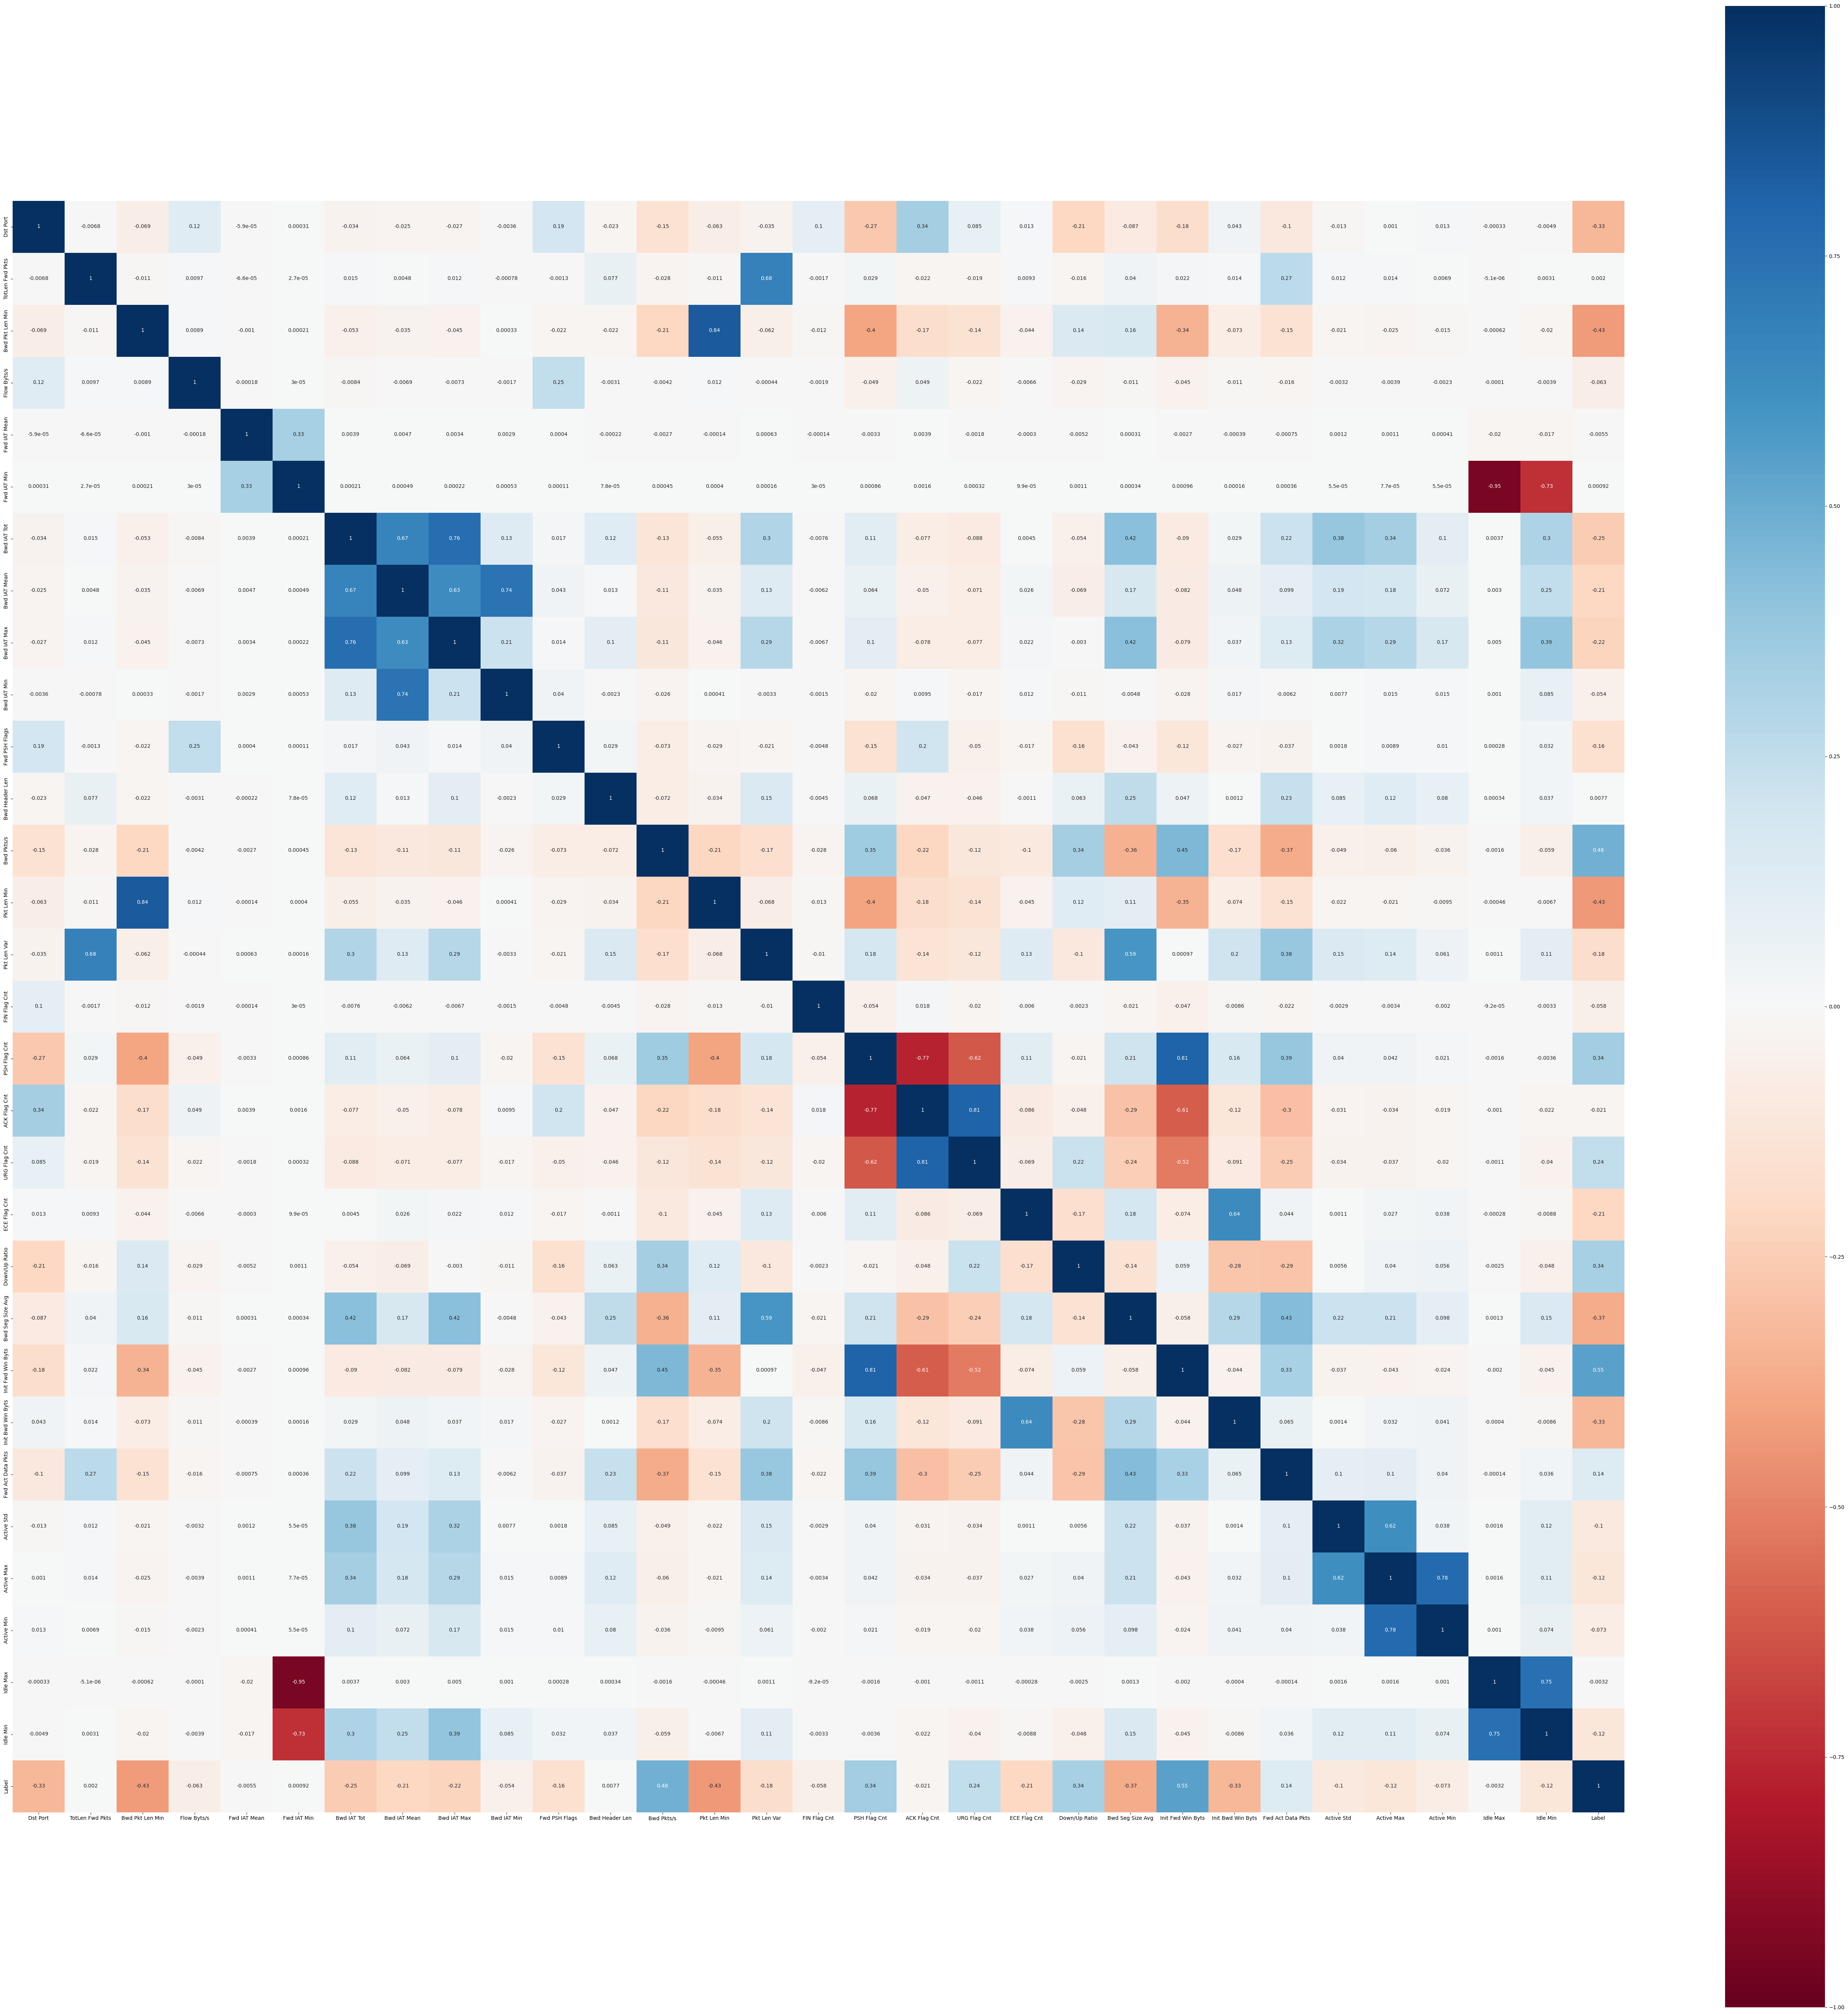

In [ ]:
# pearson correlation heatmap
plt.figure(figsize=(70, 70))
corr = network_data_d1.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='RdBu', vmin=-1, vmax=1, square=True) # annot=True
plt.show()

### **Recursive Feature Elimination (RFE) with Cross-Vlidation**

In [ ]:
# # # split data into features and target
# X=network_data_d1.drop(["Label"], axis=1)
# y=network_data_d1["Label"]

In [ ]:
# # %%time
# # # applying RFE with CV
# dt = DecisionTreeClassifier()
# cv = StratifiedKFold(5)
# min_features = 1

# rfecv = RFECV(estimator=dt, step=1, cv=cv, scoring="accuracy", min_features_to_select=min_features, n_jobs=2)
# rfecv.fit(X, y)

In [ ]:
# # num_selected_features = rfecv.n_features_
# selected_features = X.columns[rfecv.support_]
# print(num_selected_features)
# print(selected_features)

In [ ]:
# network_data_d1 = network_data_d1.loc[:, selected_features]
# network_data_d1

In [ ]:
# # presenting number of feature vs accuracy
# num_scores = len(rfecv.cv_results_["mean_test_score"])
# plt.figure()
# plt.xlabel("Number of Selected Features")
# plt.ylabel("Mean Test Accuracy")
# plt.errorbar(
#     range(min_features, num_scores + min_features),
#     rfecv.cv_results_["mean_test_score"],
#     yerr=rfecv.cv_results_["std_test_score"],
# )
# plt.title("Recursive Feature Elimination")
# plt.show()

### **Sequential Feature Selection**

In [ ]:
# # split data into features and target
# X=network_data_d1.drop(["Label"], axis=1)
# y=network_data_d1["Label"]

#### **Forward Feature Selection**

In [ ]:
# %%time
# # applying forward feature selection
# dt = DecisionTreeClassifier()
# sfs_forward = SequentialFeatureSelector(
#     dt, n_features_to_select=35, direction="forward"
# ).fit(X, y)

In [ ]:
# selected_features = X.columns[sfs_forward.get_support()]
# print(selected_features)

In [ ]:
# network_data_d1 = network_data_d1.loc[:, selected_features]
# network_data_d1

#### **Backward Feature Selection**

In [ ]:
# %%time
# # applying backward feature selection
# dt = DecisionTreeClassifier()
# sfs_backward = SequentialFeatureSelector(
#     dt, n_features_to_select=35, direction="backward"
# ).fit(X, y)

In [ ]:
# selected_features = X.columns[sfs_backward.get_support()]
# print(selected_features)

In [ ]:
# network_data_d1 = network_data_d1.loc[:, selected_features]
# network_data_d1

# **Classification**
Here many algoritms will be used to classify the data.

### **Split Data**

In [ ]:
X=network_data_d1.drop(["Label"], axis=1)
y=network_data_d1["Label"]

# split the data for evaluation
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state =42, shuffle=True)

# K-fold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

## **LazyClassifier**

In [ ]:
# LazyClassifier
# clf = LazyClassifier(verbose = 0,
#                      ignore_warnings = True,
#                      custom_metric = None,
#                      predictions = False,
#                      random_state = 12,
#                      classifiers = 'all')

# models, predictions = clf.fit(X_train, X_test, y_train, y_test)
# models

## **Decision Tree**

In [ ]:
%%time
# create a Decision Tree model
dt = DecisionTreeClassifier()

# predict
y_pred = cross_val_predict(dt, X, y, cv=kf)

print ("Dicision Tree")
# generate report
print("Performance Matrix:")
print(classification_report(y, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y, y_pred))

Dicision Tree
Performance Matrix:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    663808
           1       1.00      1.00      1.00   1327616

    accuracy                           1.00   1991424
   macro avg       1.00      1.00      1.00   1991424
weighted avg       1.00      1.00      1.00   1991424


Confusion Matrix:
[[ 663806       2]
 [      0 1327616]]
CPU times: user 1min 6s, sys: 980 ms, total: 1min 7s
Wall time: 1min 12s


## **Random Forest**

In [ ]:
# %%time
# create a Random Forest model
rf = RandomForestClassifier()

# predict
y_pred = cross_val_predict(rf, X, y, cv=kf)

print ("Random Forest")
# generate report
print("Performance Matrix:")
print(classification_report(y, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y, y_pred))

Random Forest
Performance Matrix:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    663808
           1       1.00      1.00      1.00   1327616

    accuracy                           1.00   1991424
   macro avg       1.00      1.00      1.00   1991424
weighted avg       1.00      1.00      1.00   1991424


Confusion Matrix:
[[ 663806       2]
 [      0 1327616]]


## **Support Vector Classifier (SVC)**

In [ ]:
# %%time
# create a SVC model
svc = SVC()

# predict
y_pred = cross_val_predict(svc, X, y, cv=kf)

print ("Support Vector Classifier")
# generate report
print("Performance Matrix:")
print(classification_report(y, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y, y_pred))

# **Explainable Artificial Intelligence (XAI)**

### **Split Data**

In [ ]:
X=network_data_d1.drop(["Label"], axis=1)
y=network_data_d1["Label"]

# split the data for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state =42, shuffle=True)

# K-fold
# kf = KFold(n_splits=10, shuffle=True, random_state=42)

## **LIME**

In [ ]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)
cr = classification_report(y_test, y_pred)
print(cr)

In [ ]:
lime = LimeTabular(data=X_train, random_state=1, model = dtc)
lime_local = lime.explain_local(X_test[-5:], y_test[-5:], name='LIME')

show(lime_local)

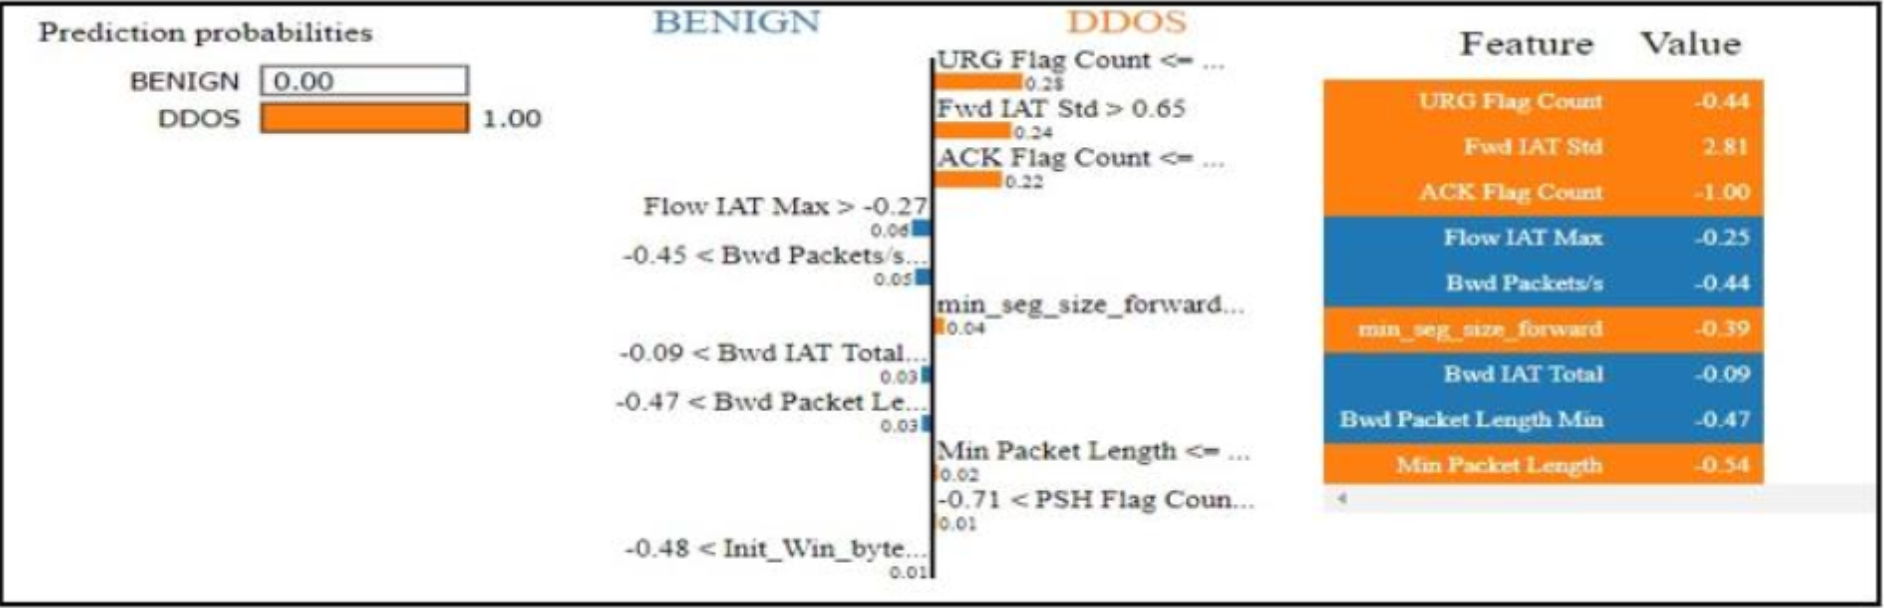